In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from IPython.display import display

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tools.get_describe_record import get_describe_record

In [2]:
raw_df = pd.read_excel("../data/raw/kadai.xlsx")
raw_df.head(2)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.2,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.8,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [3]:
processe = raw_df.copy()
processe["batch_id"] = processe.groupby("process_end_time").ngroup()
processe.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,batch_id
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0


In [4]:
tagged_anormaly = pd.read_csv("../data/processed/processe_tagged_anormaly.csv")
tagged_anormaly.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X77,X78,X79,X80,X81,X82,X83,batch_id,batch_OV_std,is_anomaly
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1


In [5]:
anomaly = tagged_anormaly[tagged_anormaly["is_anomaly"] == 1]
nomaly = tagged_anormaly[tagged_anormaly["is_anomaly"] == 0]

## 異常スパイク部分の予測モデル構築

In [6]:
train_df = anomaly[anomaly["batch_id"] < 75]
test_df = anomaly[anomaly["batch_id"] >= 75]

train_df = train_df.drop(columns=["is_anomaly","batch_OV_std", "batch_id", "process_end_time", "final_mes_time"])
test_df = test_df.drop(columns=["is_anomaly","batch_OV_std", "batch_id", "process_end_time", "final_mes_time"])

display(train_df)
display(test_df)

,OV,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,111.28860,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
1,201.56170,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,33.98,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
2,111.94100,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,10.44,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
3,182.39140,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
4,196.27030,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,115.27540,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1317,192.31780,25.85,1.18,490.90,0.82,0.15,0.07,309.24,14.61,13.89,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1318,91.62728,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1319,101.93840,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04


,OV,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
1846,127.71120,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1847,139.05970,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1848,259.36600,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1849,78.71875,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1850,77.78309,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,164.41780,24.94,56.62,655.34,0.62,0.14,0.07,25.69,2.19,14.11,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2190,285.22330,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2191,395.77340,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2192,115.75990,24.94,56.62,655.34,0.62,0.14,0.07,25.69,2.19,14.11,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38


In [7]:

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
SENSOR_COLS = [f"X{i}" for i in [27, 30, 41, 25, 36]]
LAGS = [1, 2, 3, 5, 10, 20]
WINS = [3, 5, 10, 20]   # rolling window
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
"""
"X36", "X27","X30", "X41"
X30    0.671984
X41    0.368569
X27    0.353834
X25    0.337130
"""
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  

def feature_engineering1(df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS):
    base = df[SENSOR_COLS].copy()
    feats = {}  # ★ここに全部貯める

    for c in SENSOR_COLS:
        s = df[c]

        # lag
        for l in LAGS:
            feats[f"{c}_lag{l}"] = s.shift(l)

        # diff / pct
        feats[f"{c}_diff1"] = s.diff(1)
        feats[f"{c}_diff2"] = s.diff(2)
        feats[f"{c}_pct1"]  = s.pct_change(1).replace([np.inf, -np.inf], np.nan)

        # rolling
        for w in WINS:
            r = s.rolling(w, min_periods=1)
            rmean = r.mean()
            rstd  = r.std()
            feats[f"{c}_rmean{w}"] = rmean
            feats[f"{c}_rstd{w}"]  = rstd
            feats[f"{c}_rmax{w}"]  = r.max()
            feats[f"{c}_rmin{w}"]  = r.min()
            feats[f"{c}_z{w}"]     = (s - rmean) / (rstd + 1e-9)
            feats[f"{c}_dev{w}"]   = s - rmean
        
        feats[f"{c}_energy"] = (
            feats[f"{c}_rstd20"] * feats[f"{c}_rmax20"]
        )

        feats[f"{c}_jump"] = s - s.shift(5)

    feat_df = pd.concat([base, pd.DataFrame(feats, index=df.index)], axis=1)
    feat_df = feat_df.ffill().bfill().fillna(0)
    return feat_df
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  


train_feature_df = feature_engineering1(train_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS)
test_feature_df = feature_engineering1(test_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS)
train_feature_df.head()

,X27,X30,X41,X25,X36,X27_lag1,X27_lag2,X27_lag3,X27_lag5,X27_lag10,...,X36_z10,X36_dev10,X36_rmean20,X36_rstd20,X36_rmax20,X36_rmin20,X36_z20,X36_dev20,X36_energy,X36_jump
0,3.5,1.2,0.11,0.84,0.0,3.5,3.5,3.5,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.9,3.7,0.03,0.23,0.0,3.5,3.5,3.5,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,1.2,0.11,0.84,0.0,7.9,3.5,3.5,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.5,1.2,0.11,0.84,0.0,3.5,7.9,3.5,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.9,3.7,0.03,0.23,0.0,3.5,3.5,7.9,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import pickle

# spike用特徴量
X_sp = train_feature_df
y_sp = np.log1p(train_df["OV"].values)

# 高OVを重くする（まずは80%点を基準）
q = np.percentile(train_df["OV"].values, 90)  # “頂点”の境界
w = np.ones_like(train_df["OV"].values, dtype=float)
w[train_df["OV"].values >= q] = 1 + ((train_df["OV"].values[train_df["OV"].values >= q] / (q+1e-9))**3)
w = np.clip(w, 1.0, np.percentile(w, 95))

spike_predict_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=18,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

spike_predict_model.fit(X_sp, y_sp, sample_weight=w)

with open("../data/model/spike_predict_rf.pkl", "wb") as f:
    pickle.dump(spike_predict_model, f)

## 平常時の予測

In [9]:
feat =["process_end_time", "final_mes_time", "OV"]+  [f"X{i}" for i in range(1, 84)]

train_df = nomaly.loc[nomaly["batch_id"] < 75, feat]
test_df  = nomaly.loc[nomaly["batch_id"] >= 75, feat]

display(train_df)
display(test_df)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
75,2016-09-05 07:02:00,2016-10-10 16:10:00,232.76840,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.03,0.04,7.5,0.18,0.0,5.9,0.00,0.03,0.19,0.03
76,2016-09-05 07:02:00,2016-10-10 21:53:00,203.99410,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.03,0.04,7.5,0.18,0.0,5.9,0.00,0.03,0.19,0.03
77,2016-09-05 07:02:00,2016-10-11 02:24:00,214.65380,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.03,0.04,7.5,0.18,0.0,5.9,0.00,0.03,0.19,0.03
78,2016-09-05 07:02:00,2016-10-11 07:10:00,189.10500,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.03,0.04,7.5,0.18,0.0,5.9,0.00,0.03,0.19,0.03
79,2016-09-05 07:02:00,2016-10-11 11:16:00,198.91220,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.03,0.04,7.5,0.18,0.0,5.9,0.00,0.03,0.19,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,2016-11-27 02:23:00,2017-01-13 00:47:00,82.84555,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1762,2016-11-27 02:23:00,2017-01-13 02:04:00,78.26471,24.35,4.92,635.52,0.64,0.14,0.09,78.09,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1763,2016-11-27 02:23:00,2017-01-13 04:58:00,101.99680,24.35,4.92,635.52,0.64,0.14,0.09,78.09,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1764,2016-11-27 02:23:00,2017-01-13 06:08:00,90.90938,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04


,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
1766,2016-11-28 07:26:00,2017-01-18 04:01:00,144.50520,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1767,2016-11-28 07:26:00,2017-01-18 05:01:00,107.27810,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1768,2016-11-28 07:26:00,2017-01-18 08:04:00,145.55110,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1769,2016-11-28 07:26:00,2017-01-18 09:05:00,110.57250,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
1770,2016-11-28 07:26:00,2017-01-18 09:31:00,120.00390,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,2016-12-24 20:05:00,2017-01-28 15:31:00,74.94453,25.22,14.40,397.21,0.59,0.14,0.08,38.31,...,0.03,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03
2272,2016-12-24 20:05:00,2017-01-28 19:18:00,59.39213,24.94,56.62,655.34,0.62,0.14,0.07,25.69,...,0.03,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03
2273,2016-12-24 20:05:00,2017-01-28 19:28:00,70.32605,25.22,14.40,397.21,0.59,0.14,0.08,38.31,...,0.03,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03
2274,2016-12-24 20:05:00,2017-01-28 19:28:00,77.89170,25.22,14.40,397.21,0.59,0.14,0.08,38.31,...,0.03,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03


In [10]:
def df_set_datetime(df, col_name):
    for col in col_name:
        df[col] = pd.to_datetime(df[col])
    return df

# process_end_timeを用いて経過時間, ラグを取得する。
def get_elapsed_day(df, base_time=None):
    if base_time == None:
        base_time = df['process_end_time'].min()
    df['elapsed_day'] = (df['process_end_time'] - base_time).dt.days
    return df

def set_LagOV(df,target="OV", lag_record_num=1, window=3):
    df[f"{target}_lag{lag_record_num}"] = df[target].shift(lag_record_num)
    df[f"{target}_diff"] = df[target].diff(1).shift(1)  
    df[f"{target}_roll_mean{window}"] = df[target].rolling(window).mean().shift(1)
    df[f"{target}_roll_std{window}"] = df[target].rolling(window).std().shift(1)
    #df = df.dropna().reset_index(drop=True)
    return df

def feature_engineering2(df, normal_features):
    df = df.copy()
    df = df_set_datetime(df, ["process_end_time", "final_mes_time"])
    df = get_elapsed_day(df)
    df = set_LagOV(df)
    df = df.drop(columns=[col for col in df.columns if col not in normal_features])
    return df


normal_features = ["X14", "X30", "X33", "X83"] + ["elapsed_day", "OV_lag1", "OV_diff", "OV_roll_mean3", "OV_roll_std3", "OV"]
train_df = feature_engineering2(train_df, normal_features)
test_df = feature_engineering2(test_df, normal_features)
train_df.head()

,OV,X14,X30,X33,X83,elapsed_day,OV_lag1,OV_diff,OV_roll_mean3,OV_roll_std3
75,232.7684,40.57,3.7,1.5,0.03,0,NaN,NaN,NaN,NaN
76,203.9941,40.57,3.7,1.5,0.03,0,232.7684,NaN,NaN,NaN
77,214.6538,40.57,3.7,1.5,0.03,0,203.9941,-28.7743,NaN,NaN
78,189.1050,40.57,3.7,1.5,0.03,0,214.6538,10.6597,217.138767,14.547212
79,198.9122,40.57,3.7,1.5,0.03,0,189.1050,-25.5488,202.584300,12.832613


In [11]:
pipeline = Pipeline([
    #("scaler", StandardScaler()),
    ("scaler", StandardScaler()),
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        verbose=-1,
        random_state=42
    ))
])

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
normal_features = ["X14", "X30", "X33", "X83"] + ["elapsed_day", "OV_lag1", "OV_diff", "OV_roll_mean3", "OV_roll_std3", "OV"]

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  

train_X = train_df[normal_features].drop(columns=["OV"])
pipeline.fit(train_X, train_df["OV"])

with open("../data/model/non_spike_predict.pkl", "wb") as f:
    pickle.dump(pipeline, f)

test_X = test_df[normal_features].drop(columns=["OV"])
pred = pipeline.predict(test_X)

rmse = np.sqrt(mean_squared_error(test_df["OV"], pred))
print(f"RMSE (nomaly only): {rmse:.3f}")

RMSE (nomaly only): 26.567


# 全体予測

In [12]:
with open("../data/model/spike_detection_IFmodel.pkl", "rb") as f:
    spike_model = pickle.load(f)

with open("../data/model/spike_predict_rf.pkl", "rb") as f:
    spike_predict_model = pickle.load(f)

with open("../data/model/non_spike_predict.pkl", "rb") as f:
    non_spike_predict_model = pickle.load(f)

with open("../data/score/IF_train_score.pkl", "rb") as f:
    score_train = pickle.load(f)
thr = np.quantile(score_train, 0.90)

In [13]:
# スパイク発生ロット
SENSOR_COLS = [f"X{i}" for i in [27, 30, 41, 25, 36]]
LAGS = [1, 2, 3, 5, 10, 20]
WINS = [3, 5, 10, 20]   # rolling window

# 通常ロット
normal_features = ["X14", "X30", "X33", "X83"] + ["elapsed_day", "OV_lag1", "OV_diff", "OV_roll_mean3", "OV_roll_std3"]

RMSE all   : 50.496
RMSE spike : 79.407
RMSE normal: 31.148


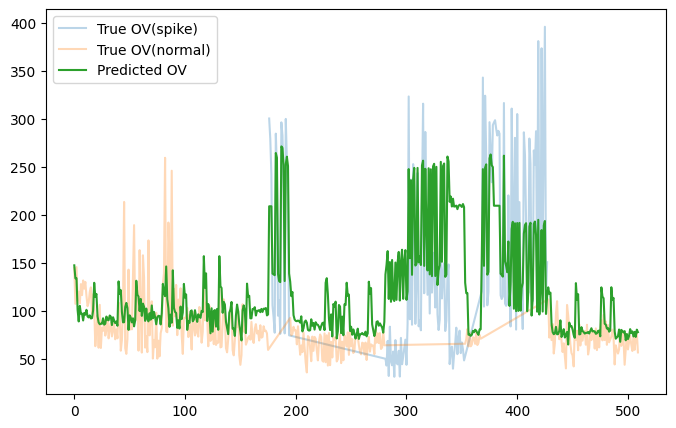

In [14]:
rows = []

for batch in range(75, 100):

    batch_df = processe[processe["batch_id"] == batch]
    batch_OV = batch_df["OV"].values

    # --- スパイク判定 ---
    desc_df = get_describe_record(df=processe, batch=batch)
    if hasattr(desc_df, "ndim") and desc_df.ndim == 1:
        desc_df = desc_df.to_frame().T

    score_test = -spike_model.score_samples(desc_df)
    is_spike = int((score_test >= thr).item())

    # --- 予測 ---
    if is_spike == 1:
        feature_df = feature_engineering1(
            batch_df,
            SENSOR_COLS=SENSOR_COLS,
            LAGS=LAGS,
            WINS=WINS
        )
        pred = spike_predict_model.predict(feature_df)
        pred = np.expm1(pred)
    else:
        feature_df = feature_engineering2(
            batch_df,
            normal_features
        )
        pred = non_spike_predict_model.predict(feature_df)

    # --- val_df に追加（★ここが重要） ---
    tmp_df = pd.DataFrame({
        "trueOV": batch_OV,
        "predOV": pred,
        "batch_id": batch,
        "is_spike": is_spike
    })
    rows.append(tmp_df)

val_df = pd.concat(rows, ignore_index=True)

rmse_all = np.sqrt(mean_squared_error(val_df["trueOV"], val_df["predOV"]))
rmse_sp  = np.sqrt(mean_squared_error(val_df.loc[val_df["is_spike"]==1,"trueOV"],
                                      val_df.loc[val_df["is_spike"]==1,"predOV"]))
rmse_no  = np.sqrt(mean_squared_error(val_df.loc[val_df["is_spike"]==0,"trueOV"],
                                      val_df.loc[val_df["is_spike"]==0,"predOV"]))

print(f"RMSE all   : {rmse_all:.3f}")
print(f"RMSE spike : {rmse_sp:.3f}")
print(f"RMSE normal: {rmse_no:.3f}")

plt.figure(figsize=(8, 5))
mask_spike = val_df["is_spike"] == 1
plt.plot(val_df.index[mask_spike], val_df["trueOV"][mask_spike], label="True OV(spike)", alpha=0.3)
mask_normal = val_df["is_spike"] == 0
plt.plot(val_df.index[mask_normal], val_df["trueOV"][mask_normal], label="True OV(normal)", alpha=0.3)
plt.plot(val_df.index, val_df["predOV"], label="Predicted OV")

plt.legend()
plt.show()
